## **Ground-truth masks generator**

This notebook aims to generate binary masks to identify ground-truths cloud areas in the images.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import *
import skimage.filters
from utilities import *
from mask_generator import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

import multiprocessing
num_cores = multiprocessing.cpu_count()
from joblib import parallel_backend, Parallel, delayed
from dask.distributed import Client
client = Client()

import glob
import random
random.seed(a=10)

%matplotlib widget

#### **Open FITS image with astropy**

In [2]:
image = fits.getdata('2023_01_23_22_26_21_341990_flux.fits')

#### **Plot image in raw ADU**

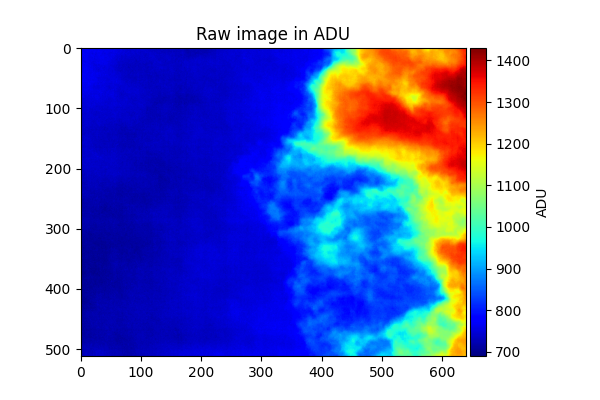

In [7]:
plt.figure(figsize=(6,4))
plt.title('Raw image in ADU')
plt.imshow(image, cmap='jet')
plt.colorbar(label='ADU', pad=0.01)
plt.show()

#### **Linearize image with S-shape curve response**

#### $\mathcal{S}_{xy}' = ln(\frac{DR}{\mathcal{S}_{xy}} - 1)$ 

In [8]:
## Linearize image with S-shape curve
DR = 2**14
image_linearized = np.log((DR/image) - 1)

#### **Plot linearized image**

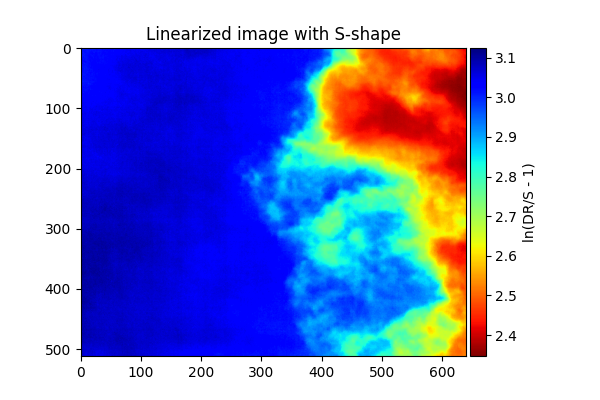

In [9]:
plt.figure(figsize=(6,4))
plt.title('Linearized image with S-shape')
plt.imshow(image_linearized, cmap='jet_r')
plt.colorbar(label='ln(DR/S - 1)', pad=0.01)
plt.show()

#### **Apply stretch to the image to reveal cloud structure**

In [10]:
image_div = image/DR
stretch = LogStretch(a=100000) + ZScaleInterval(contrast=0.9)

In [11]:
image_stretch = stretch(image_div)

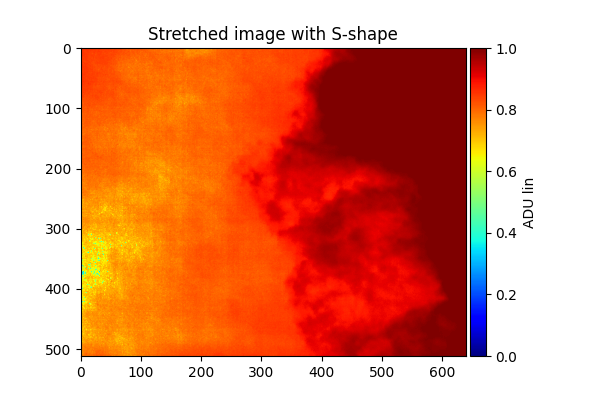

In [12]:
plt.figure(figsize=(6,4))
plt.title('Stretched image with S-shape')
plt.imshow(image_stretch, cmap='jet')
plt.colorbar(label='ADU lin', pad=0.01)
plt.show()

#### **Compute automatic threshold value for the mask with skimage tool**
https://datacarpentry.org/image-processing/07-thresholding.html

In [15]:
t = skimage.filters.threshold_otsu(image_stretch)
binary_mask = image_stretch > t
print("Found automatic threshold t = {}.".format(t))

Found automatic threshold t = 0.876953125.


#### **Create ground truth binary mask**

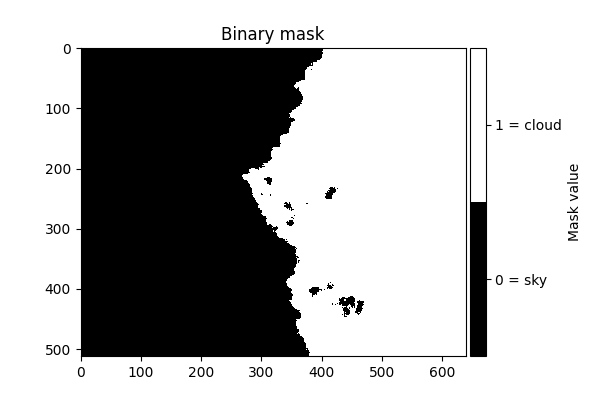

In [16]:
plt.figure(figsize=(6,4))
plt.title('Binary mask')

N = 2
plt.imshow(binary_mask, cmap=discrete_cmap(N, 'gray'))
cbar = plt.colorbar(label='Mask value', pad=0.01, ticks=range(N))
plt.clim(-0.5, N - 0.5)
cbar.ax.set_yticklabels(['0 = sky', '1 = cloud'])  # vertically oriented colorbar

plt.show()

Found automatic threshold t = 0.876953125.


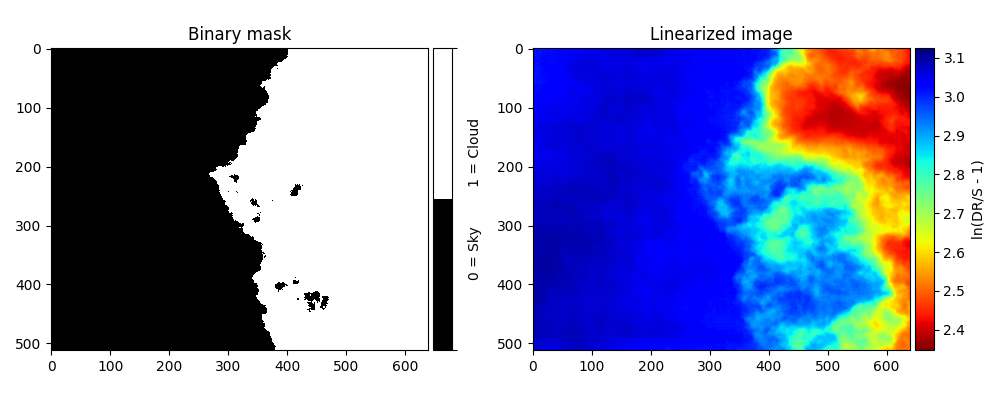

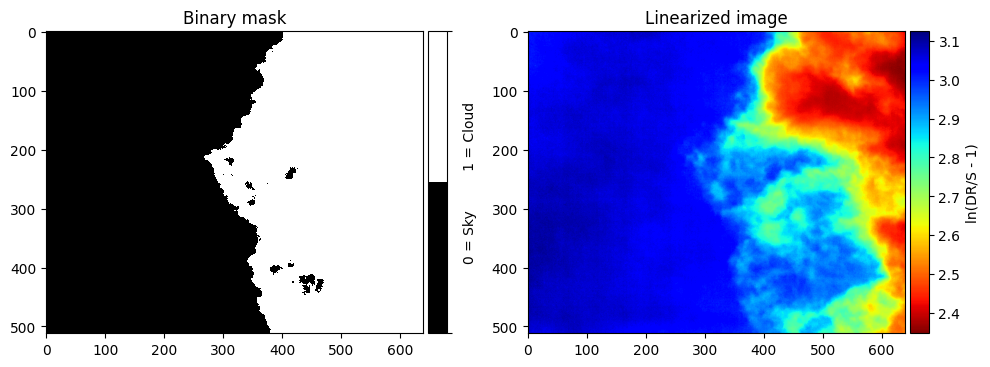

In [14]:
generate_mask(filename='2023_01_23_22_26_21_341990_flux.fits', a_log = 100000, contrast = 0.9, display = True, return_mask=False, write_to_fits=False)

#### **Snippet to select the subset of 5000 images and create mask for them**

In [12]:

images_list = glob.glob('../SUBSET_5000/*.fits')
r_list = random.choices(images_list, k=len(images_list))


In [13]:
def read_fits_file(filename):
    return fits.open(filename)

with parallel_backend('threading', n_jobs=num_cores):
    l_fits = Parallel(verbose=5)(delayed(read_fits_file)(filename=r) for r in r_list)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 2162 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 3026 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 3512 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    2.

In [14]:

with parallel_backend('threading', n_jobs=num_cores):
    l_plots = Parallel(verbose=10)(delayed(generate_mask)(filename = r, a_log = 100000, contrast = 0.9,
                                                          display = False, return_mask = False, write_to_fits = True) for r in r_list)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Para